In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.special import softmax

import nengo
import nengo_dl
import tensorflow as tf
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import sorted_neurons
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

In [10]:
### Useful functions
def Perturb(x, n=0, p=0.):
    '''
        y = Perturb(x, n=0, p=0.)
        
        Apply binary noise to x. With probability p, each bit will be randomly
        set to -1 or 1.
        
        Inputs:
          x is an array of binary vectors of {-1,1}
          p is the probability of each bit being randomly flipped (n=0)
          n is the number of bits to flip (p=0)
        
        Output:
          y is a matrix of binary vectors {-1,1}
    '''
    y = copy.deepcopy(x)
    for yy in y:
        if p>0:
            for k in range(len(yy)):
                if np.random.rand()<p:
                    #yy[k] = Thresh(np.random.randint(2)*2-1)
                    yy[k] *= -1
        if n>0:
            k = np.random.choice(len(yy), n, replace=False)
            for i in k:
                yy[i] *= -1
    return y


def ham(X, Y):
    mul = np.multiply(X, Y)
    H = 0
    for i in mul:
        if i<=0:
            H=H+1       
    return H


def Hamming(X, Y):
    '''
     H = Hamming(X, Y)
     
     Computes the Hamming distance between rows of X and Y.
     If X and/or Y have multiple rows, then the output will
     be an array.
     
     Inputs:
      X   (M,D) array
      Y   (N,D) array
      
     Output:
      H   (M,N) array
    '''
    H = np.zeros((len(X), len(Y)), dtype=int)
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            H[i,j] = np.sum(x*y<=0.)
    return H

In [11]:
#Function for contructing dataset for training decoders 
def V_train(X, N_samples):
    #Contains copies of X AND noisy copies of X
    Nh, Nv = np.shape(X)    
    V_tr = X
    #Copies of X
    for i in range( int( 0.7*(N_samples-1) ) ):
        V_tr = np.vstack((V_tr, X))
    #Noisy copies of X   
    for i in range(int( 0.3*(N_samples) ) ):
        V_tr = np.vstack( (V_tr, X + np.random.normal(0, 0.1, size=X.shape)) )
                   
    #V_tr = V_tr.reshape( (N_samples, Nh, Nv) ) 
    print('samples:', np.shape(V_tr))

    return V_tr

#Function for constructing feature targets for training decoders (eval_points)
def V_targ(X, N_samples):
    #Contains copies o X only
    Nh, Nv = np.shape(X)    
    
    V_t = X
    for i in range( int( (N_samples-1) ) ):
        V_t = np.vstack((V_t, X))
        
    #V_t = V_t.reshape( (N_samples, Nh, Nv) )
    return V_t

#Function for constructing hidden targets for training decoders (eval_points)
def H_targ(X, N_samples):
    Nh, Nv = np.shape(X)    
    H_t = X@X.T
    for i in range( int( (N_samples-1) ) ):
        H_t = np.vstack((H_t, X@X.T))
        
    #H_t = H_t.reshape( (N_samples, Nh, Nh) )
    H_t = np.c_[H_t, np.ones(N_samples*Nh)]
    return H_t

#Function for constructing eval_points for c ensemble
def c_targ(X, N_samples):
    Nh, Nv = np.shape(X)    
    C_t = Nv
    for i in range(int(N_samples - 1)):
        C_t = np.vstack( (C_t, Nv + np.random.normal(0.1, 0.01) ) )
    
    return C_t

#Function for constructing eval_points for f ensemble
def f_targ(X, N_samples):
    Nh, Nv = np.shape(X)    
    h = X@X.T
    f_t = h - np.log(np.sum(np.exp(h), axis = 0))
    #for i in range(int(N_samples - 1)):
    #    C_t = np.vstack( (C_t, Nv + np.random.normal(0.1, 0.01) ) )
    
    return f_t

In [12]:
## Create targets
X = np.random.binomial(n=1, p=0.5, size=(20, 14))
XX = 2*X - 1 
Nh, Nv = np.shape(X)
print(XX)

[[ 1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1]
 [ 1 -1  1 -1  1 -1 -1 -1  1  1 -1  1  1  1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1  1]
 [ 1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1 -1  1  1  1  1 -1 -1  1]
 [-1  1  1  1  1 -1  1 -1 -1 -1 -1 -1  1  1]
 [ 1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1]
 [-1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1  1]
 [-1 -1  1  1 -1 -1  1 -1  1 -1  1  1  1  1]
 [ 1  1 -1 -1 -1  1  1  1 -1  1  1  1 -1  1]
 [ 1  1 -1  1 -1  1  1 -1 -1 -1  1  1  1  1]
 [ 1  1 -1 -1 -1  1  1  1 -1  1  1 -1 -1 -1]
 [-1  1  1  1  1  1 -1  1 -1 -1  1 -1  1  1]
 [-1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1]
 [ 1 -1 -1 -1  1  1  1  1 -1  1  1 -1  1 -1]
 [-1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1]
 [ 1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1]
 [-1  1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1]
 [ 1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1]]


In [13]:
k=0
II = XX[k] #"Correct" pattern
#I = Y[k] + 5*np.random.normal(size=Y[k].shape)     #Perturbed data (real valued perturbations)
I = Perturb( XX , n=0, p=0.1 )                      #Perturbed the data (binary perturbations)
I = I[k]
hamm = ham(I, II)
print(f'Correct pattern({k}):', II)

hams=Hamming([I], XX)
print(f'Hamming between target {k} and input I : {ham(II, I)}')
closest_patterns = np.flatnonzero(hams == hams.min())
np.argmin(Hamming([I], XX))
print(hams)
print(f'Closest pattern to input I: {closest_patterns}')

Correct pattern(0): [ 1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1]
Hamming between target 0 and input I : 2
[[ 2  9 10  7 11  7  6  7  8  7  8  8  6  4  5  5  5 10  7  7]]
Closest pattern to input I: [0]


In [14]:
inp_train = V_train(XX, 100)
v_targ = V_targ(XX, 10)
h_targ = H_targ(XX, 10)
C_targ = c_targ(XX, 100)
F_targ = f_targ(XX, 100)

samples: (2000, 14)


In [18]:
t_I = 2
G = 1
tau_h = 0.1
tau_v = 0.1
Ntype = nengo.Direct() #Direct()

model = nengo.Network()
with model:
    inp = nengo.Node(Piecewise({0: 1*I, t_I: np.zeros_like(XX[0])}))
    beta = nengo.Node(Piecewise({0: 1, t_I: 0})) #create a beta node to be held in the 'extra dimension' in hidden pop
    
    v = nengo.Ensemble(1000, dimensions=Nv, radius = np.sqrt(1), neuron_type = Ntype) #feature population 
    h = nengo.Ensemble(1000, dimensions=Nh+1, radius=np.sqrt(1), neuron_type = Ntype) #hidden population (representing Nh-D 1hot representation)
    
    #connect nodes
    nengo.Connection(inp, v, synapse = tau_v) #connect input to feature neurons 
    nengo.Connection(beta, h[-1]) #connect beta to the last dimension of hidden pop
    
    
    #connections to feature population:
    nengo.Connection(v, v, function = lambda x: (1-(1/tau_v))*x, transform = 1, synapse = tau_v, eval_points = v_targ) 
    nengo.Connection(h, v, function=lambda h: (G-h[-1])*XX.T@softmax(h[:-1]), transform = 1,
                     synapse = tau_v, eval_points = h_targ)
    
    
    #connections to hidden population
    nengo.Connection(v, h[:-1], function=lambda x: G*XX@x, transform = 1, synapse = tau_h, eval_points = v_targ)
    nengo.Connection(h[:-1], h[:-1], function = lambda x : (1-(1/tau_h))*x, transform = 1, synapse = tau_h)

    
    #Probe input, feature, and hidden neurons
    inp_p = nengo.Probe(inp)
    v_p = nengo.Probe(v, synapse=0.2)
    h_p = nengo.Probe(h[:-1], synapse=0.5)
    beta_p = nengo.Probe(beta)

In [19]:
with nengo_dl.Simulator(model) as sim:
    sim.run(4.0)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:03                                                 


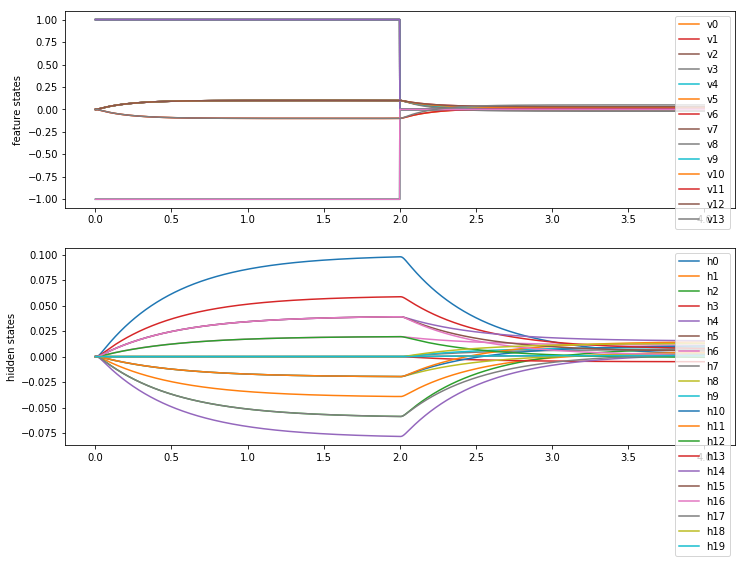

In [20]:
plt.figure(figsize=(12, 8))
#feature plot
plt.subplot(2, 1, 1)
for i in range(Nv):
    plt.plot(sim.trange(), sim.data[inp_p].T[i])
    plt.plot(sim.trange(), sim.data[v_p].T[i], label = f'v{i}')
    plt.ylabel("feature states")
    plt.legend(loc="best")
    
#hidden plot
plt.subplot(2, 1, 2)
for i in range(Nh):
    plt.plot(sim.trange(), sim.data[h_p].T[i], label=f"h{i}")
    plt.ylabel("hidden states")
    plt.legend(loc="best")

### LSE Hopfield with BIO SM

In [24]:
model = nengo.Network()
with model:
    #inp = nengo.Node(XX[1]) #input (target 0)
    inp = nengo.Node(Piecewise({0: XX[8], 2: XX[0]}))

    v = nengo.Ensemble(5000, dimensions=Nv, radius = 3)#neuron_type=nengo.Direct()) #feature population (representing Nv-D value)    
    h = nengo.Ensemble(1, dimensions=Nh, neuron_type=nengo.Direct()) #hidden population (representing Nh-D 1hot representation)
    f = nengo.Ensemble(1, dimensions=Nh, neuron_type=nengo.Direct()) 
    c = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct()) 
    

    
    #connections to feature population:
    nengo.Connection(inp, v, transform = 1)#, synapse = 1) #connect input to feature neurons recurrently
    nengo.Connection(v, v, transform = -1, eval_points = v_targ, synapse = 0.5) 
    nengo.Connection(f, v, function=lambda x: XX.T@np.exp(x), transform = 1, eval_points = F_targ, synapse = 0.5)
    
    
    #connections to f population:
    nengo.Connection(h, f, transform = 1, synapse = 0.1)
    nengo.Connection(c, f, function = lambda x: np.ones(Nh,)*x, transform = -1, eval_points = C_targ, synapse = 0.1)
    nengo.Connection(f, f, transform = -1, eval_points = F_targ, synapse = 0.1)
    
    #connections to c population
    nengo.Connection(h, c, function = lambda x: np.log(np.sum(np.exp(x), axis=0)), transform = 1, 
                      synapse = 0.1)
    nengo.Connection(c, c, function = lambda x: -1*x, transform = 1, eval_points = C_targ, synapse = 0.1)
    
    
    #connections to hidden population
    nengo.Connection(v, h, function=lambda x: 1*XX@x, transform = 1, eval_points = inp_train, synapse = 0.1)
    nengo.Connection(h, h, function = lambda x: (-1)*x, transform = 1, synapse=0.1)
    
    
    
    #Probe input, feature, and hidden neurons
    inp_p = nengo.Probe(inp)
    v_p = nengo.Probe(v, synapse=0.5)
    h_p = nengo.Probe(h, synapse=0.1)

In [25]:
with nengo.Simulator(model) as sim:
    sim.run(5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

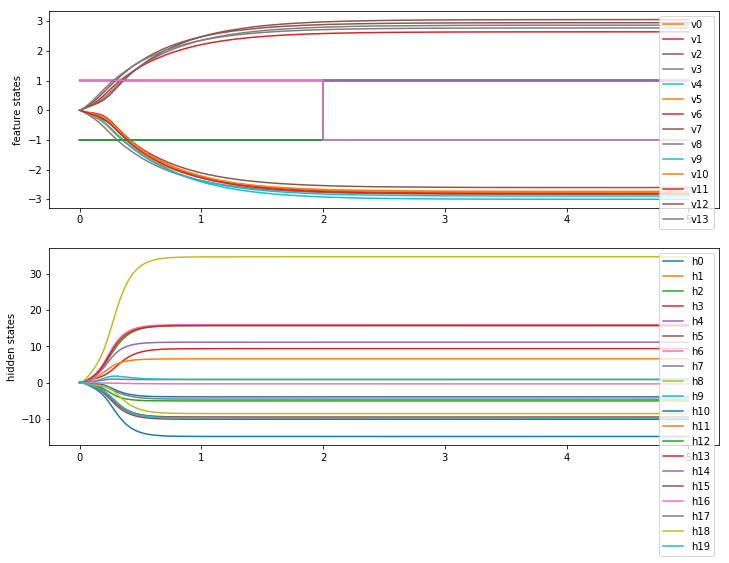

In [26]:
plt.figure(figsize=(12, 8))
#feature plot
plt.subplot(2, 1, 1)
for i in range(Nv):
    plt.plot(sim.trange(), sim.data[inp_p].T[i])
    plt.plot(sim.trange(), sim.data[v_p].T[i], label = f'v{i}')
    plt.ylabel("feature states")
    plt.legend(loc="best")
    
#hidden plot
plt.subplot(2, 1, 2)
for i in range(Nh):
    plt.plot(sim.trange(), sim.data[h_p].T[i], label=f"h{i}")
    plt.ylabel("hidden states")
    plt.legend(loc="best")

In [27]:
k_conv = np.argmax(sim.data[h_p][-1])
print(f'network converges to pattern {k_conv}')
print('softmax(h):', softmax(sim.data[h_p][-1]))

network converges to pattern 8
softmax(h): [2.49719904e-22 4.77173731e-20 5.49886144e-09 9.14068433e-12
 4.27892688e-20 2.90565445e-20 6.96635473e-09 1.72043503e-15
 9.99999982e-01 1.86029851e-15 1.44797835e-17 5.39448046e-13
 4.70645980e-18 5.44303230e-09 5.42812539e-11 5.51859933e-20
 5.26818632e-16 7.68393833e-18 1.40310228e-19 4.25090454e-20]


### Altering Dyamics
#### (Creating feedback functions as seen in The Lorenz chaotic attractor example)

In [29]:
tau_h = 0.5
tau_v=0.5
def feedback(VHI):
    v = VHI[     :Nv   ]
    h = VHI[Nv   :Nv+Nh]
    I = VHI[Nv+Nh:     ]
    
    dv = XX.T@softmax(h) - 2*v + I
    dh = XX@v - h
    
    v_new = dv*tau_v + v
    h_new = dh*tau_h + h
    
    VHI_new =  np.concatenate([v_new, h_new, I])
    #VHI_new =  np.concatenate([v_new, h_new])

    return  VHI_new

In [30]:
model = nengo.Network()
with model:
    inp = nengo.Node(XX[k]) #input
    #inp = nengo.Node(Piecewise({0: XX[0], 4: np.zeros_like(XX[0])}))

    
    VHI = nengo.Ensemble(1000, dimensions=2*Nv+Nh, radius = np.sqrt(2*Nv+Nh)) #feature population[:Nv] + hidden popultion[Nv:Nh] + input[Nv+Nh:]
    #VHI = nengo.Ensemble(2000, dimensions=Nv+Nh, radius = 4) #feature population[:Nv] + hidden popultion[Nv:Nh] + input[Nv+Nh:]

    
    nengo.Connection(inp, VHI[Nv+Nh:], transform = 1) #connect input to input section of VHI
    
    nengo.Connection(VHI, VHI, function = feedback, synapse = 0.01)

In [31]:
with model :
    v_p = nengo.Probe(VHI[:Nv], synapse = 0.1)
    h_p = nengo.Probe(VHI[Nv:Nv+Nh], synapse = 0.1)
    #inp_p = nengo.Probe(VHI[Nv+Nh:])
    inpp = nengo.Probe(inp)

In [32]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

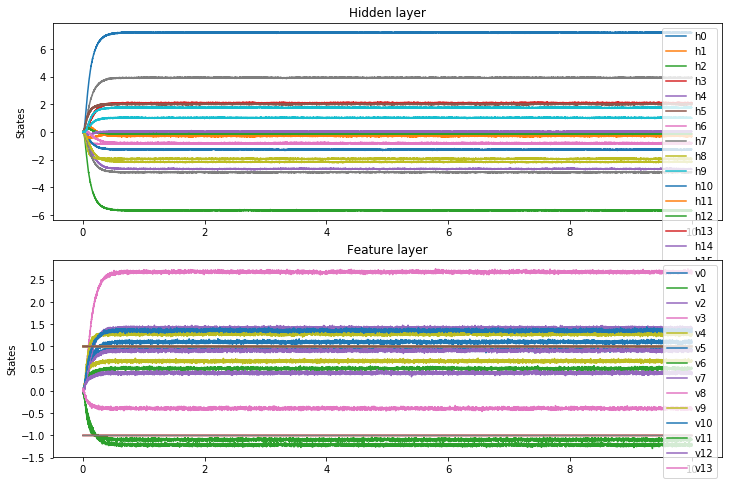

In [33]:
plt.figure(figsize=(12, 8))
#hidden plot
plt.subplot(2, 1, 1)
for i in range(Nh):
    plt.plot(sim.trange(), sim.data[h_p].T[i], label=f"h{i}")
    plt.ylabel("States")
    plt.legend(loc="best")
    plt.title('Hidden layer')
plt.subplot(2, 1, 2)
for i in range(Nv):
    plt.plot(sim.trange(), sim.data[v_p].T[i], label=f"v{i}")
    plt.ylabel("States")
    plt.plot(sim.trange(), sim.data[inpp].T[i])

    plt.legend(loc="best")
    plt.title('Feature layer')

In [34]:
k_conv = np.argmax(sim.data[h_p][-1])
print(f'network converges to pattern {k_conv}')
print(softmax(sim.data[h_p][-1]))

network converges to pattern 0
[9.31934404e-01 5.24676581e-04 2.34814743e-06 5.65511547e-03
 4.77099276e-05 5.39613761e-03 3.06899404e-04 3.63865443e-02
 9.95366825e-05 1.89387455e-03 2.01639733e-04 5.90042681e-04
 6.14555419e-04 5.74193828e-03 7.24064631e-04 5.28906953e-03
 3.24061197e-04 3.84181663e-05 8.08401998e-05 4.14812353e-03]
